## Learnings from Time Series, a Kaggle Course
Trend - component of time series representing long-term change in the mean of the series.  
It is slowest moving part of a time series, and largest time scale of importance.  
Can be any persistent, slow moving change in a series, but focusing on mean trends in this course

A moving average plot is a way to discover a trend in a time series.  
Moving average - computed from average of values in some window of time (width), left and right of the current step in the time series.  
Smooths out short-term fluctuations in a time series, hopefully leaving and show only long-term changes.

Time dummy:  target = a * time + b  
Quadratic time dummy:  target = a * time ** 2 + b * time + c  
Linear regression:  learns the a, b (and c if present) coefficients  

Important:  Linear regression can fit curves other than lines.  
            Need to provide curves of right shape as features so it can learn to combine them in a way that best fits the target

In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
simplefilter("ignore")

In [4]:
# setup plot defaults / style
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False
)
%config InlineBackend.figure_format = 'retina'

In [5]:
# load traffic data
tunnel = pd.read_csv("./time_series_demo/tunnel.csv", parse_dates=['Day'])
tunnel = tunnel.set_index('Day').to_period()

Data has daily observations of number of vehicles, will try a window of 365 days for the moving average.  
Hope is to smooth over any short-term changes within the year.  
Create a moving average using rolling method, which defines a window.  
Then chain the mean method to compute the average over the window.

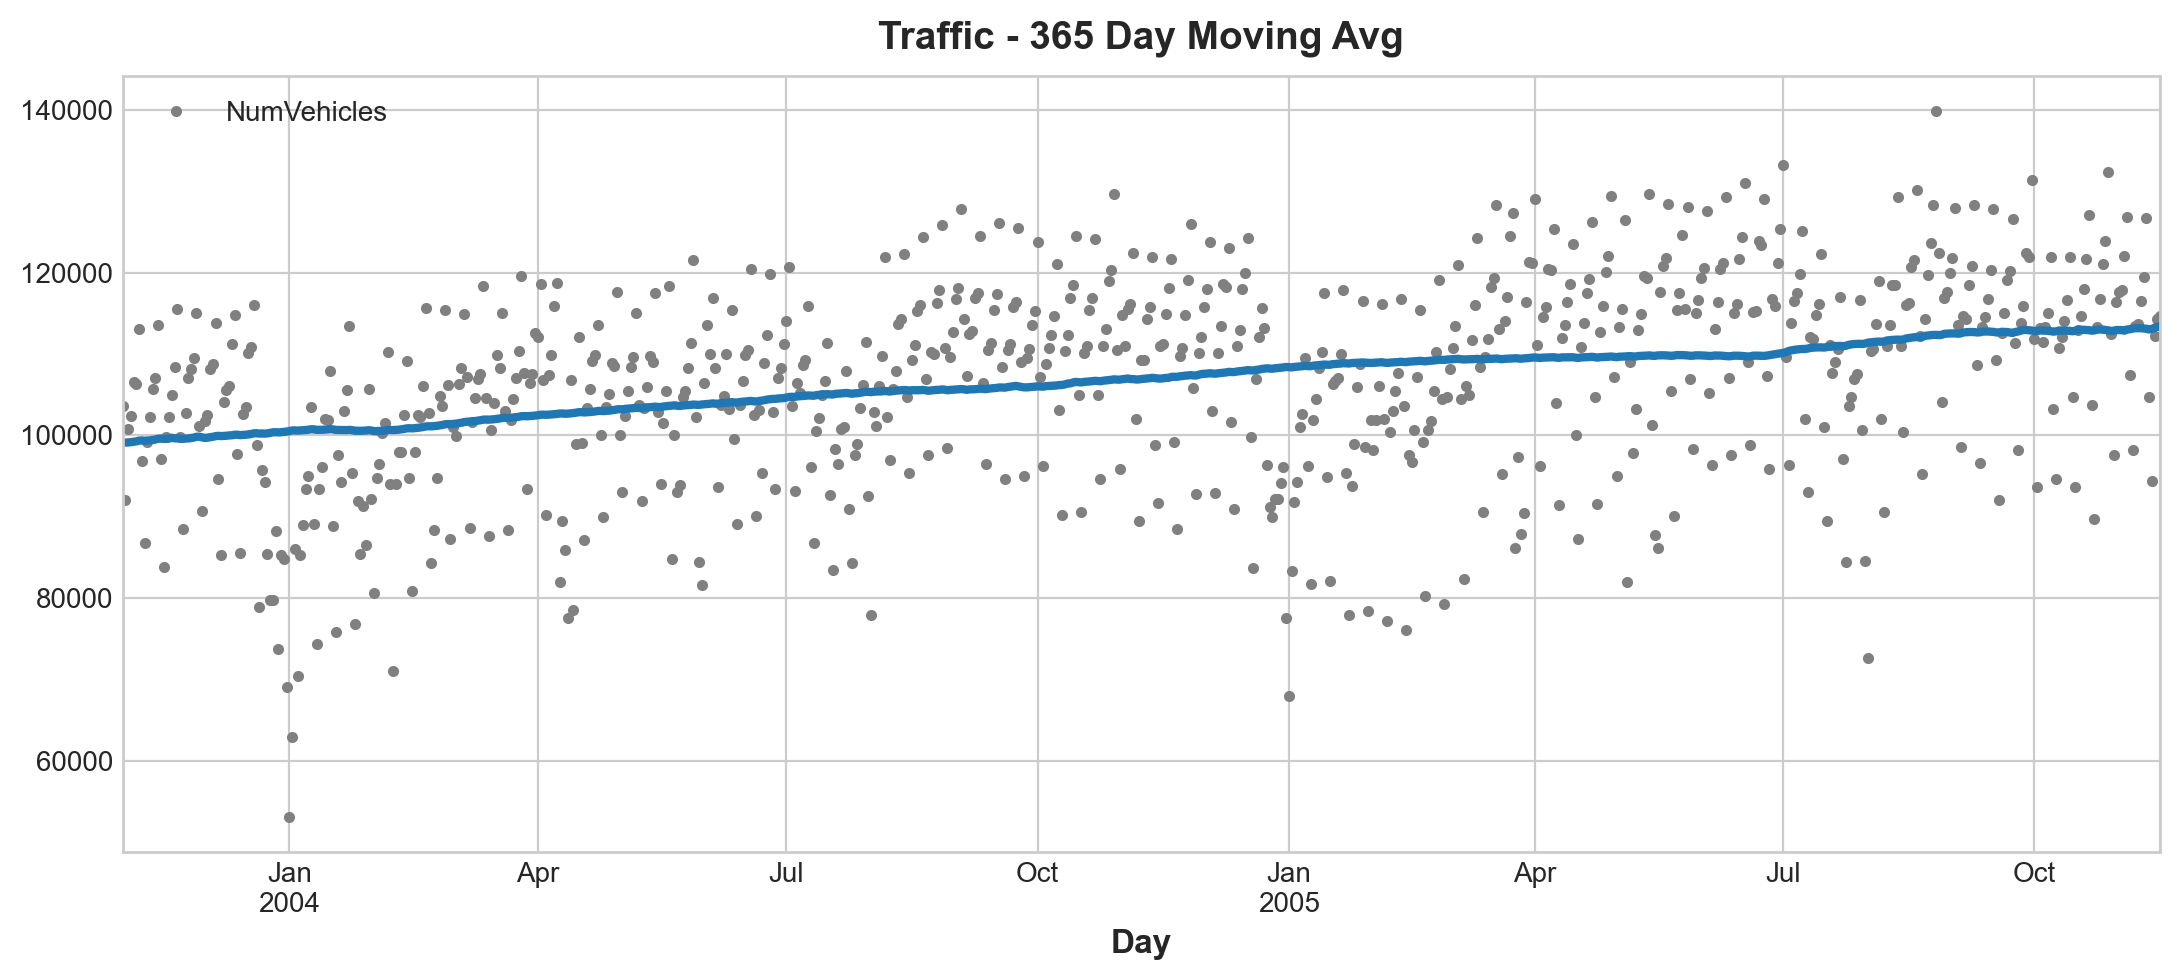

In [6]:
moving_average = tunnel.rolling(
    window=365,      # 365 observation window
    center=True,     # sets average at cetner of window
    min_periods=183, # use about half the window size
).mean()             # comput the mean (could do median, std, min, max, etc.)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax,
    linewidth=3,
    title="Traffic - 365 Day Moving Avg",
    legend=False
);

There appears to be a mostly linear trend.  
Install and use statsmodels libray, DeterministicProcess class to get a time dummy instead of engineering with Pandas.  
pip install statsmodels in the kernel.

This will avoid failure cases that can arise with time series and linear regerssion (but which ones?)
* index - dates from training data
* constant - set to True for dummy feature for the bias (y_intercept)
* order - 1 is linear, 2 is quadratic, 3 is cubic, and so on
* drop - set to True to drop terms if necessary to avoid collinearity

A determinsic process is a time series that is non-random or completely determined (like trend series).  Features derived from the time index will generally be deterministic).

In [8]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,
    order=1,
    drop=True
)

# use 'in_sample' to create features for the dates given in the index
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


Create the trend model using linear regression

Info about constant=True:  
* instructs class to include constant term in generated features, known as bias or intercept in regression models
* it adds a column in the feature matrix (X) where all values are 1
* represents the value of the dependent variable (y) when all the independent variables (X) are zero.
* for time series modeling, data may not pass through the origin and this constant adjusts models predictions accordingly
* better fits data that doesn't start at the origin, shifting regerssion line up or down.
* crucial to accuratly model and predict/forcast, as it sets a baseline level for the dependent variable not explained by other predictors.

In [11]:
from sklearn.linear_model import LinearRegression

# target - aka what model should predict
y = tunnel['NumVehicles'] 

# fit_intercept = false excludes the intercept, which is the same as the const
# need to exclude it or it'd be duplicated in the linear regression and that is bad
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

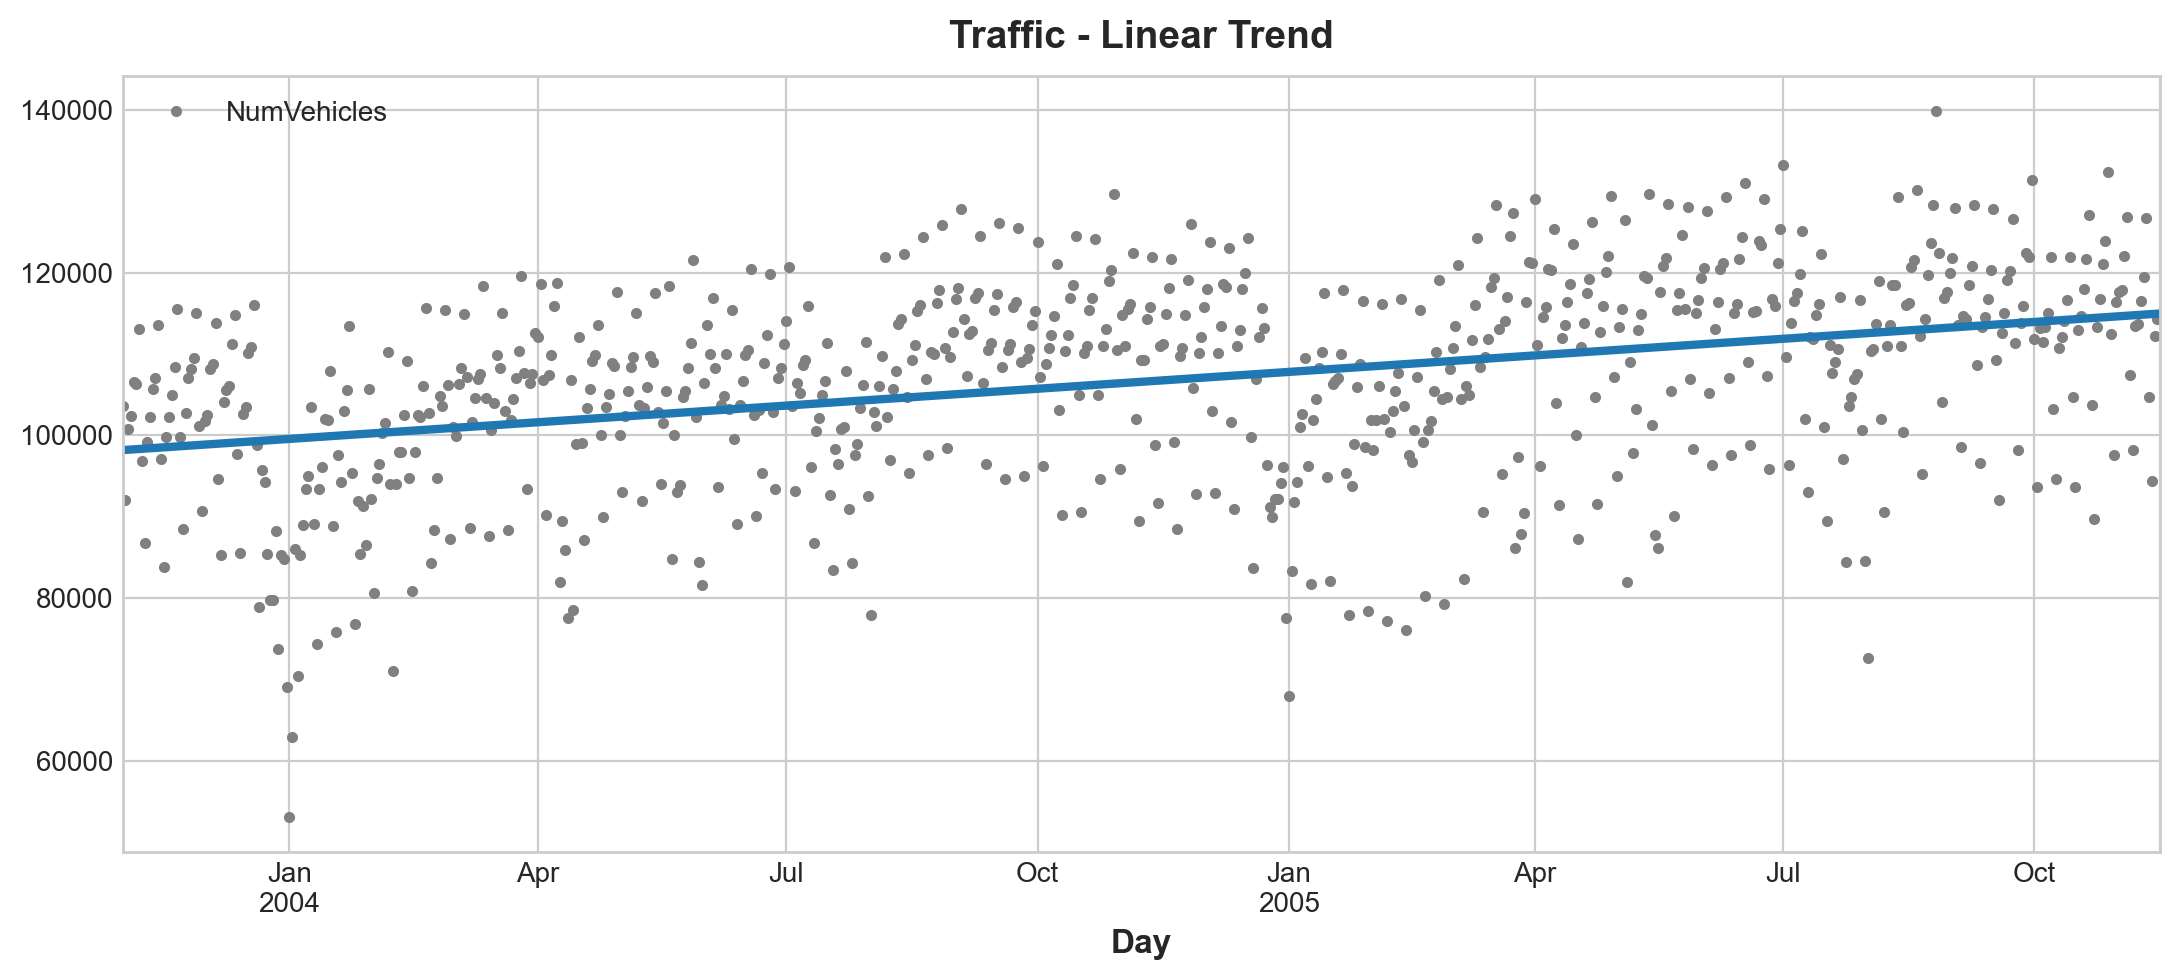

In [12]:
#create the plot
ax = tunnel.plot(
    style=".",
    color="0.5",
    title="Traffic - Linear Trend"
)
_ = y_pred.plot(
    ax=ax,
    linewidth=3,
    label="Trend"
)

### Now to use the model to predict, making a 30-day forecast.
Use out of sample method on the created deterministic process  
This will apply the model to predict values for time outside the observation window  
Give it some amount of steps, in this case 30 for 30 days

In [13]:
X = dp.out_of_sample(steps=30)
y_forecast = pd.Series(model.predict(X), index=X.index)
y_forecast.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

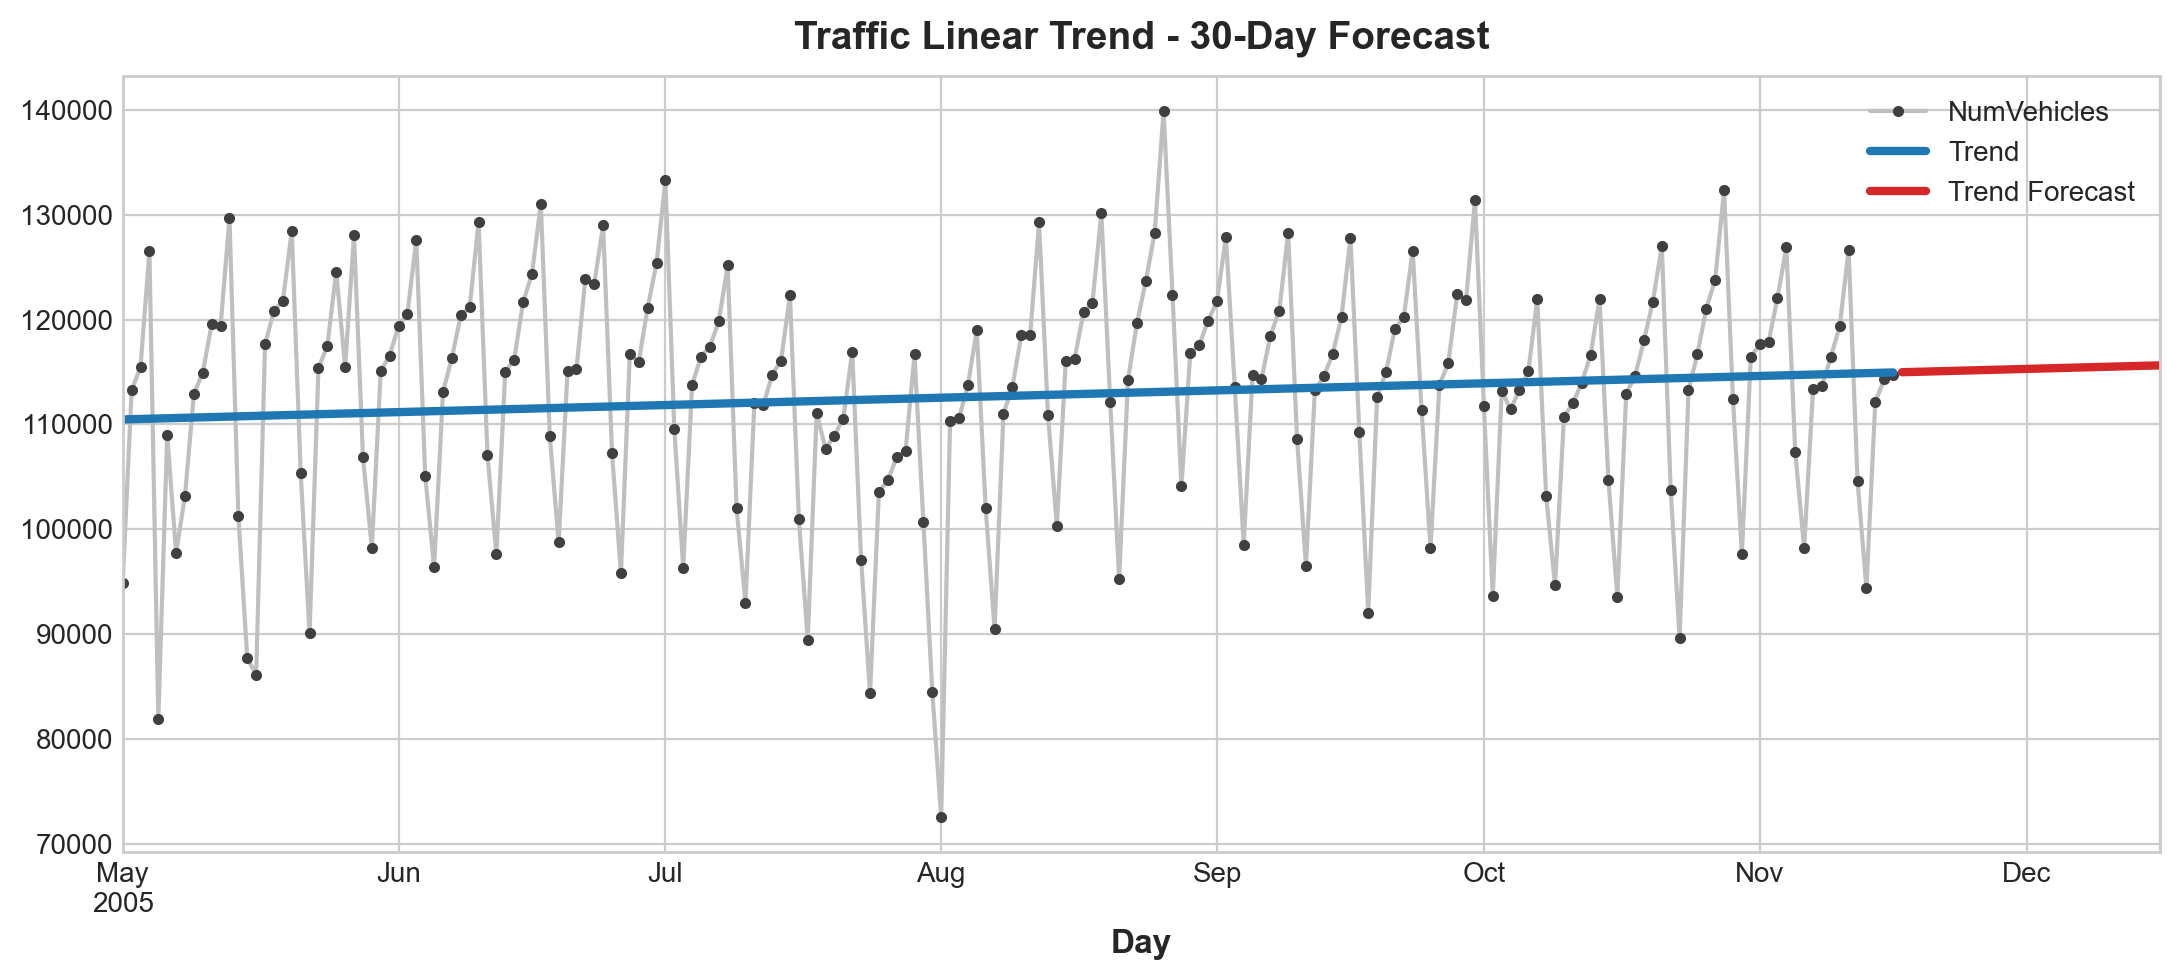

In [16]:
# then create a plot to actually see the 30 days forecast
ax = tunnel["2005-05":].plot(title="Traffic Linear Trend - 30-Day Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

The trend models can act as a baseline / starting point for more sophisticated models and can use them as a component in hybrid models with algorithms that don't learn trends (XGB and random forest).